### Импорт библиотек

In [1]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import string
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import xgboost


c:\users\svetamira\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\svetamira\miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
c:\users\svetamira\miniconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


### Зафиксированные значения

In [2]:
RANDOM_SEED = 42

### Используемые функции

In [3]:
def build_plot(column, data_frame):
    plt.figure(figsize=(12, 6))
    sns.set()
    sns.countplot(x=column, data=data_frame).set_xticklabels(sns.countplot(x=column, data=data_frame).get_xticklabels(), 
                                                  rotation=40, ha="right", fontsize=14)
    plt.tight_layout()
    plt.show()
    
def heatmap(data):
    plt.figure(figsize=(12, 6))
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm')

def build_log_plot(x, data):
    plt.figure(figsize=(10, 7))
    g1 = sns.boxplot(y='log_price', x=x, data=data, color='lightblue')
    g1.set_ylabel("log_price", fontsize=15)
    g1.set_xticklabels(g1.get_xticklabels(),rotation=40)
    plt.show()
    
def outliers_iqr(x):
    quartile_1, quartile_3 = np.percentile(x, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)    
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def mape_2(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.round(mape(y_test, y_pred)*100, 4)

### Загрузка и изучение датасета из kaggle

In [4]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
test.head(10)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
5,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia_r...,серый,"{""id"":""5011515"",""name"":""RS"",""available_options...",Продаю свой автомобиль! Автомобиль полностью и...,2.0 LTR,200 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 2.0,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
6,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1101...,пурпурный,"{""id"":""20069264"",""name"":""Elegance"",""available_...",- выгода 60 000 рублей при покупке авто в Trad...,1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,ALLROAD_5_DOORS ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
7,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01214644\nАвтопрага Юг\n\nВы можете получ...,1.6 LTR,102 N12,"{""asr"":true,""tinted-glass"":true,""airbag-driver...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
8,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,бежевый,NaN,ЛОТ: 01217938\nАвтопрага Север\nДанный автомоб...,1.4 LTR,150 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,ALLROAD_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
9,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1101...,белый,NaN,ЛОТ: 01222831\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""asr"":true,""tinted-glass"":true,""esp"":true,""ai...",бензин,...,ALLROAD_5_DOORS MECHANICAL 1.8,механическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [6]:
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

Тестовый датасет состоит из следующих 32 столбцов:

bodyType - тип автомобиля  
brand - марка автомобиля  
car_url - ссылка на объявление на сайте auto.ru  
color - цвет автомобиля  
complectation_dict - словарь с описанием комплектаций  
description - описание с сайта auto.ru  
engineDisplacement - объем двигателя  
enginePower - мощность двигателя  
equipment_dict - словарь с описанием  
fuelType - тип топлива  
image - изображение автомобиля с сайта auto.ru  
mileage - пробег  
modelDate - год выпуска  
model_info - информация о модели автомобиля  
model_name - модель автомобиля  
name - информация по объему и мощности двигателя  
numberOfDoors - количество дверей  
parsing_unixtime - время парсинга  
priceCurrency - указанная валюта в объявлении  
productionDate - год выпуска  
sell_id - ID продавца  
super_gen - общая информация об автомобиле  
vendor - производитель  
Владельцы - количество владельцев  
Владение - срок службы автомобиля  
ПТС - информация о ПТС  
Привод - тип привода  
Руль - сторона руля  
Состояние - состояние автомобиля  
Таможня - информация о таможне  

Почти во всех столбцах значения корректные, кроме столбца parsing_unixtime, преобразуем его в привычный формат, оставив только год:

In [7]:
test['sale_year'] = test['parsing_unixtime'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)

В столбцах complectation_dict, equipment_dict, Владение присутствуют пустые значения

In [8]:
print('Размерность тестового датасета: ', test.shape)

Размерность тестового датасета:  (34686, 33)


Посмотрев на данные внутри тестового датасета, делаем вывод о удалении следующих столбцов:

complectation_dict - слишком много пустых значений  
description - слишком много разнородной информации  
image - неинформативно для целевой переменной  
model_info - содержит в себе информацию из других столбцов  
name - содержит в себе информацию из других столбцов  
priceCurrency - все цены указаны в рублях  
sell_id - неинформативно  
super_gen - содержит в себе информацию из других столбцов  
vehicleConfiguration - содержит в себе информацию из других столбцов  
Владение - слишком много пустых значений  
Состояние - все автомобили не требуют ремонта  
Таможня - все автомобили растаможены  

In [9]:
columns_to_drop = ['complectation_dict', 'description', 
                   'image', 'model_info', 'name',  
                   'priceCurrency', 'sell_id','parsing_unixtime',
                   'super_gen', 'vehicleConfiguration',
                   'Владение', 'Состояние', 'Таможня'] 
test = test.drop(columns_to_drop, axis=1)

In [10]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'numberOfDoors', 'productionDate', 'vehicleTransmission',
       'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'sale_year'],
      dtype='object')

### Рассмотрим подробнее оставшиеся столбцы тестового датасета

Проверим на наличие дубликатов объявлений: 

In [11]:
test['car_url'].nunique()

34686

В столбце все значения уникальные.  
Также судя по строке url можно узнать информацию о состоянии автомобиля - БУ или новый

In [12]:
test.car_url.apply(lambda x: x.split('/')[4]).value_counts()

used    34686
Name: car_url, dtype: int64

Все машины БУ

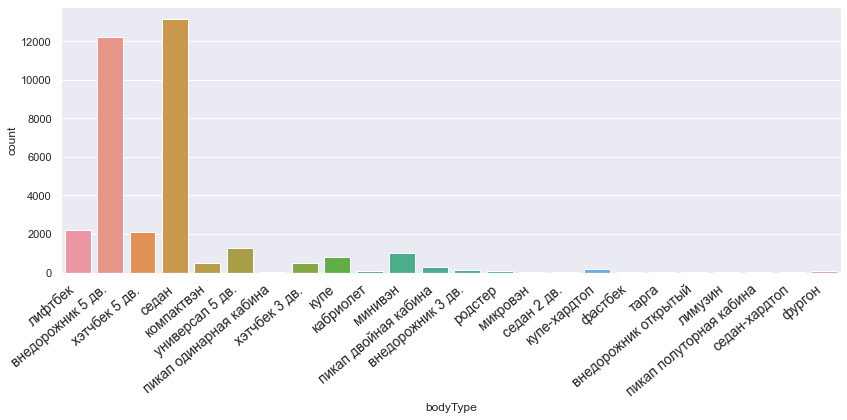

In [13]:
build_plot('bodyType', test)

Больше всего в датасете седанов и внедорожников 5 дверных

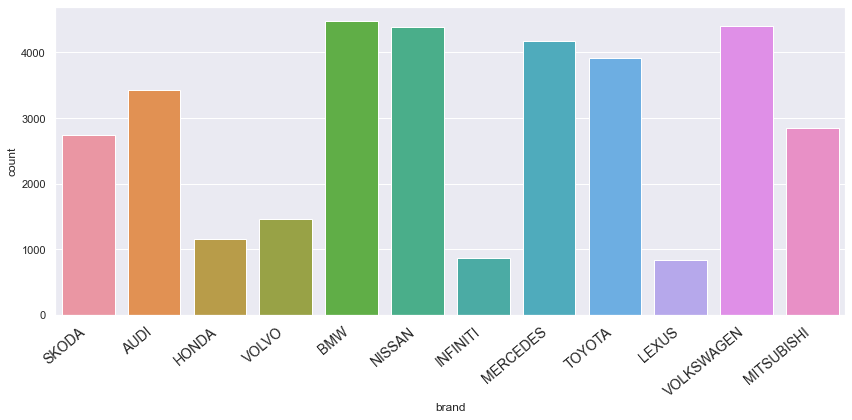

In [14]:
build_plot('brand', test)

Всего представлено 12 марок.Распределение по маркам автомобилей относительно равномерное, за исключением 4 марок. Сохраним их всех в отдельный список для последующего парсинга. 

In [15]:
brands = test.brand.value_counts().index
brands

Index(['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI',
       'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI', 'LEXUS'],
      dtype='object')

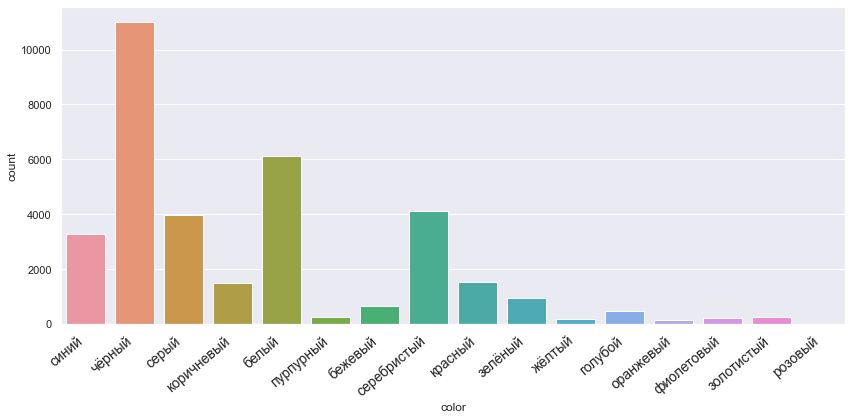

In [16]:
build_plot('color', test)

Преобладающее количество машин черного цвета

In [17]:
test['engineDisplacement'] = [''.join(re.findall("\d*\.\d+", item)) for item in test['engineDisplacement']]
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 0 if x == '' else x)
test['engineDisplacement'] = test['engineDisplacement'].values.astype('float64')
test['engineDisplacement'].value_counts(bins=4)

(1.65, 3.3]        21106
(-0.0076, 1.65]     8352
(3.3, 4.95]         4246
(4.95, 6.6]          982
Name: engineDisplacement, dtype: int64

В столбце были данные с текстом LTR, почистили его, оставив только цифры. 
Большинство машин имеют объем двигателя от 1.6 до 3.3

In [18]:
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))
test['enginePower'] = test['enginePower'].values.astype('int64')
test['enginePower'].value_counts(bins=4)

(29.389999999999997, 182.25]    20618
(182.25, 334.5]                 11963
(334.5, 486.75]                  1562
(486.75, 639.0]                   543
Name: enginePower, dtype: int64

В столбце были данные с текстом N12, почистили его, оставив только цифры. 
Большинство машин имеют мощность двигателя от 30 до 182 л.с.

In [19]:
test['equipment_dict']

0        {"engine-proof":true,"tinted-glass":true,"airb...
1        {"cruise-control":true,"asr":true,"esp":true,"...
2        {"cruise-control":true,"tinted-glass":true,"es...
3        {"cruise-control":true,"roller-blind-for-rear-...
4        {"cruise-control":true,"asr":true,"esp":true,"...
                               ...                        
34681    {"cruise-control":true,"asr":true,"tinted-glas...
34682                                                  NaN
34683                                                  NaN
34684    {"engine-proof":true,"esp":true,"start-stop-fu...
34685    {"alloy-wheel-disks":true,"navigation":true,"p...
Name: equipment_dict, Length: 34686, dtype: object

Столбец содержащий информацию по дополнительным опциям, скорее всего удалим его, но пока оставим

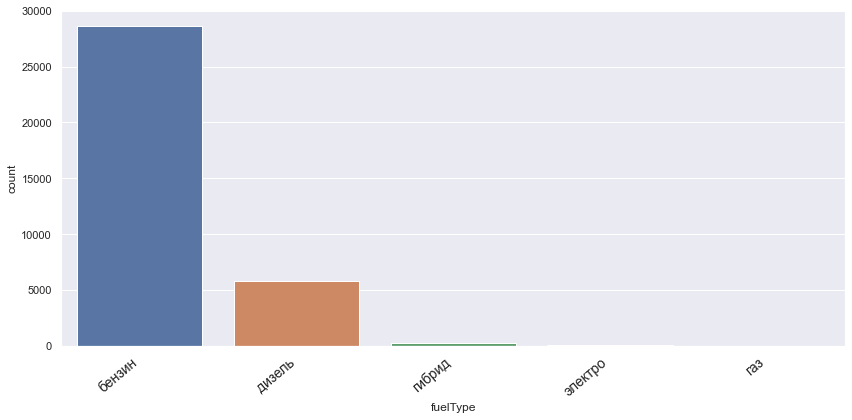

In [20]:
build_plot('fuelType', test)

Большинство машин на бензине

In [21]:
test['mileage'].value_counts(bins=4)

(-999.0, 250000.75]       29025
(250000.75, 500000.5]      5502
(500000.5, 750000.25]       126
(750000.25, 1000000.0]       33
Name: mileage, dtype: int64

In [22]:
test['mileage'].sort_values(ascending=False)

6568     1000000
9463     1000000
20164    1000000
18308    1000000
25168    1000000
          ...   
15939          1
15472          1
33607          1
31977          1
16891          1
Name: mileage, Length: 34686, dtype: int64

Странное значение -999, но после проверки оказалось что минимальное значение 1, соответственно у преобладающего количества машин пробег от 1 до 250 000 км

In [23]:
test['modelDate'].value_counts(bins=4)

(1991.0, 2020.0]      33124
(1962.0, 1991.0]       1534
(1933.0, 1962.0]         27
(1903.883, 1933.0]        1
Name: modelDate, dtype: int64

Большинство машин с 1991 по 2020 год выпуска

In [24]:
test['model_name'].value_counts()

OCTAVIA         1418
5ER             1026
LANCER           855
E_KLASSE         809
PASSAT           782
                ... 
W136               1
MEGA_CRUISER       1
FAVORIT            1
SPARKY             1
I8                 1
Name: model_name, Length: 544, dtype: int64

В датасете присутствуют 544 разных модели машины

In [25]:
test['numberOfDoors'].value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [26]:
test[test.numberOfDoors==0][['brand','model_name','modelDate']]

,brand,model_name,modelDate
16944,MERCEDES,SIMPLEX,1904


Mercedes Simplex 1904 года был без дверей, ошибки в данных нет

In [27]:
test['productionDate'].value_counts(bins=4)

(1991.0, 2020.0]      33904
(1962.0, 1991.0]        764
(1933.0, 1962.0]         17
(1903.883, 1933.0]        1
Name: productionDate, dtype: int64

Большинство машин с 1991 по 2020 год выпуска. 
Судя по полученным данным этот столбец скорее всего коррелирует со столбцом modelDate, проверим это

In [28]:
test[['productionDate', 'modelDate']].corr()

,productionDate,modelDate
productionDate,1.000000,0.974293
modelDate,0.974293,1.000000


Корреляция составляет 0.97. 
Оставим признак 'productionDate', т.к. объективно он более информативен при выборе автомобиля
Столбец modelDate - удалим

In [29]:
test.drop(['modelDate'], axis=1, inplace=True)

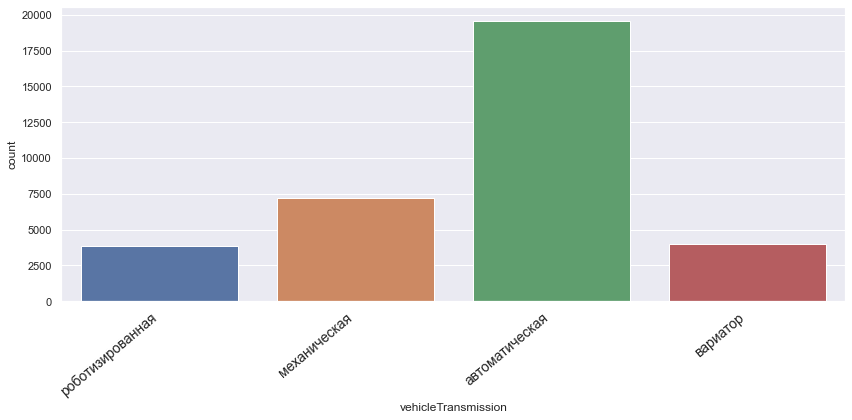

In [30]:
build_plot('vehicleTransmission', test)

Большинство машин имеют автоматическую коробку передач

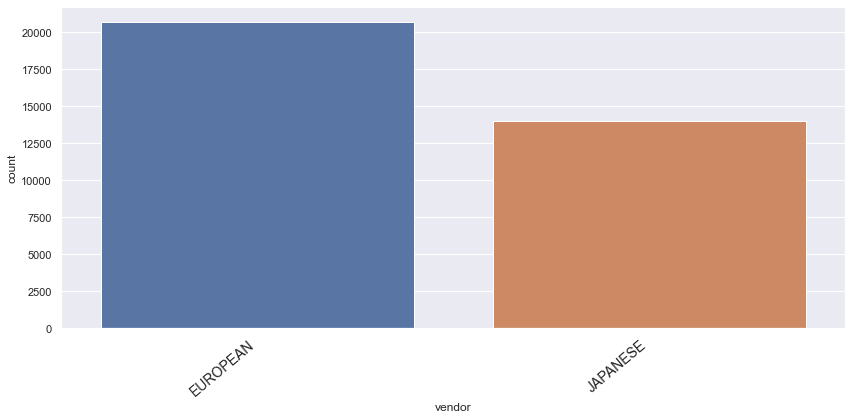

In [31]:
build_plot('vendor', test)

Большинство автомобилей европейских производителей

In [32]:
test['Владельцы'] = [''.join(re.findall("\d*\.?\d+", item)) for item in test['Владельцы']]
test['Владельцы'] = test['Владельцы'].values.astype('int64')

In [33]:
test['Владельцы'].value_counts()

3    15957
1     9459
2     9270
Name: Владельцы, dtype: int64

Так же скорректировали столбец, оставив только количество владельцев.
У большинства машин было 3 и более владельцев

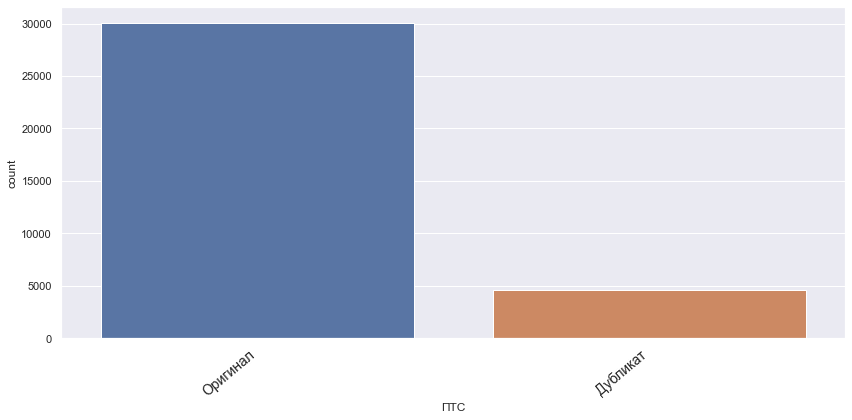

In [34]:
build_plot('ПТС', test)

Большинство ПТС - оригинал

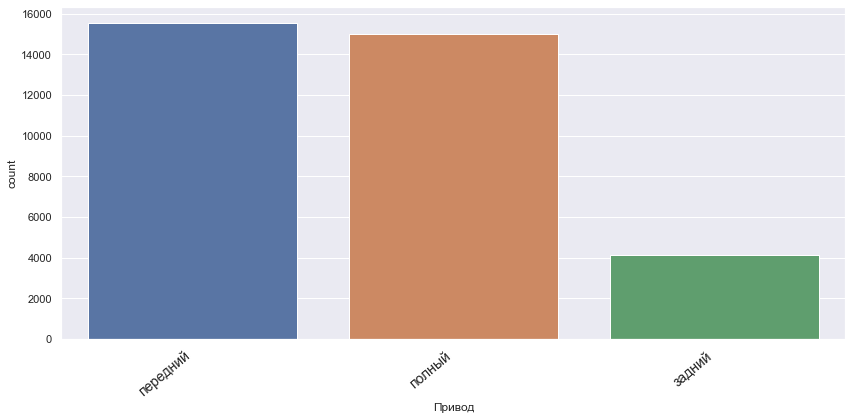

In [35]:
build_plot('Привод', test)

У большинства машин передний привод

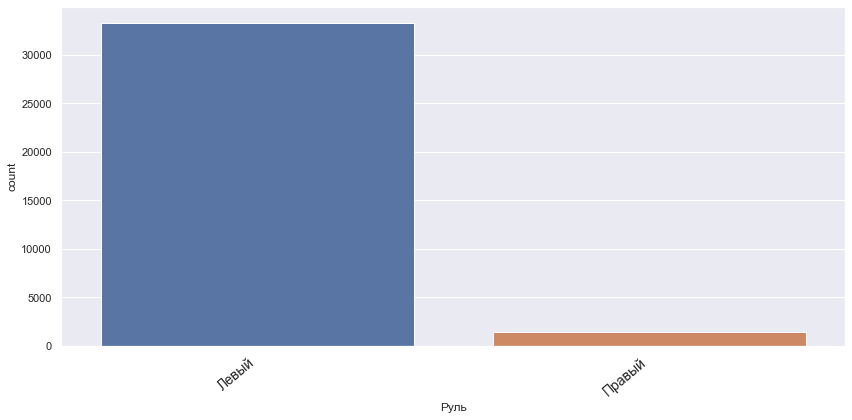

In [36]:
build_plot('Руль', test)

Большинство машин леворульные

In [37]:
print('Размерность тестового датасета: ', test.shape)

Размерность тестового датасета:  (34686, 19)


После выполненных преобразований в тестовом датасете осталось 18 столбцов

In [38]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'model_name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'sale_year'],
      dtype='object')

## Загрузка и изучение датасета полученного парсингом данных с сайта auto.ru

Судя по тестовому  датасету для парсинга выбираем БУ машины марок из списка brands.

Парсинг с auto.ru выполнялся следующим образом:  
- убираем фильтр по геолокации  
- берем фильтр по марке авто
- выбираем автомобили с пробегом 

На странице отображаются 38 объявлений. Всего страниц на каждую марку можно отобразить не более 99.  
Циклом проходим по всем доступным страницам, собирая основную информацию, представленную в объявлении (не заходя на страницы отдельных объявлений). 


In [39]:
def car_info_parser(car):
    '''функция сбора информации об авто с сайта auto.ru'''
    car_info = {'bodyType':[],'car_url':[],'color':[],'двигатель':[], 'трансмиссия':[], 'привод':[],
           'год':[],'пробег':[],'цена':[]} # определим словарь для сбора основной информации
    
    url = f'https://auto.ru/cars/{car.lower()}/used/'
    response = requests.get(url)
    response.encoding = 'utf-8'
    first_page = BeautifulSoup(response.text, 'html.parser')
    page_num = first_page.find(class_='ControlGroup ControlGroup_responsive_no ControlGroup_size_s ListingPagination-module__pages')
    last_page = int(page_num.find_all(class_='Button__text')[-1].text) # определи количество страниц, 
                                                                       # по которым будет проходить цикл

    for page in range(1,last_page):
        url_page = url + f'?page={page}'
        response_page = requests.get(url_page)
        response_page.encoding = 'utf-8'
        page = BeautifulSoup(response_page.text, 'html.parser')
        cars_page = page.find_all('div', class_='ListingItem-module__main')
        page_num = page.find('div', class_='ListingPagination-module__container')
        for i in range(len(cars_page)):     # цикл для прохода по объявлениям на странице
            car_url = cars_page[i].find(class_='Link ListingItemTitle-module__link')['href']
            car_info['car_url'].append(car_url)
            
            price = cars_page[i].find(class_='ListingItemPrice-module__content')
            car_info['цена'].append(price)
            
            year = cars_page[i].find(class_='ListingItem-module__year')
            car_info['год'].append(year.text)
            
            kmAge = cars_page[i].find(class_='ListingItem-module__kmAge')
            car_info['пробег'].append(kmAge.text.replace('\xa0', '')[:-2])
            
            auto_info = cars_page[i].find_all(class_='ListingItemTechSummaryDesktop__cell')
            model_info_list = []
            for el in range(len(auto_info)): # формирование списка доп инфы  
                model_info_list.append((str(auto_info[el].text)))
                
            car_info['двигатель'].append(model_info_list[0].replace('\u2009', ' ').replace('\xa0', ' ')) 
            car_info['трансмиссия'].append(model_info_list[1])
            car_info['bodyType'].append(model_info_list[2])
            car_info['привод'].append(model_info_list[3])
            car_info['color'].append(model_info_list[4])
    return car_info

Далее применяем функцию к маркам из списка brands. Получаем 12 словарей, из которых формируем общий тренировочный датафрейм 'df_full' 

In [40]:
train=pd.read_csv('df_full.csv')
train.head()

,Unnamed: 0,bodyType,car_url,color,двигатель,трансмиссия,привод,год,пробег,цена
0,0,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x5_m/110359...,чёрный,4.4 л / 575 л.с. / Бензин,автомат,полный,2015,53000,"<div class=""ListingItemPrice-module__content"">..."
1,1,седан,https://auto.ru/cars/used/sale/bmw/5er/1103881...,белый,3.0 л / 249 л.с. / Дизель,автомат,полный,2019,43900,"<div class=""ListingItemPrice-module__content"">..."
2,2,седан,https://auto.ru/cars/used/sale/bmw/m5/11034992...,синий,4.4 л / 625 л.с. / Бензин,автомат,полный,2020,7900,"<div class=""ListingItemPrice-module__content"">..."
3,3,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x5/11036267...,чёрный,3.0 л / 306 л.с. / Дизель,автомат,полный,2010,280000,"<div class=""ListingItemPrice-module__content"">..."
4,4,купе,https://auto.ru/cars/used/sale/bmw/m4/10767461...,синий,3.0 л / 450 л.с. / Бензин,робот,задний,2017,7200,"<div class=""ListingItemPrice-module__content"">..."


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37370 entries, 0 to 37369
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   37370 non-null  int64 
 1   bodyType     37370 non-null  object
 2   car_url      37370 non-null  object
 3   color        37370 non-null  object
 4   двигатель    37370 non-null  object
 5   трансмиссия  37370 non-null  object
 6   привод       37370 non-null  object
 7   год          37370 non-null  int64 
 8   пробег       37370 non-null  int64 
 9   цена         36852 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.9+ MB


Пропущенные данные только в целевой колонке - можно смело удалить соответствующие строки

In [42]:
train.dropna(inplace=True)

In [43]:
print('Размерность тренировочного датасета: ', train.shape)

Размерность тренировочного датасета:  (36852, 10)


In [44]:
train.columns

Index(['Unnamed: 0', 'bodyType', 'car_url', 'color', 'двигатель',
       'трансмиссия', 'привод', 'год', 'пробег', 'цена'],
      dtype='object')

Обновим индексы и удалим колонку 'Unnamed: 0'

In [45]:
train=train.reset_index()
train.drop(['index','Unnamed: 0'],axis=1,inplace=True)

Данные собирались в 2021, добавим колонку об этом:

In [46]:
train['sale_year'] = 2021

Выведем цену из html-строки

In [47]:
train['цена'] = train['цена'].apply(lambda x: x.replace('\xa0', ''))
train['цена'] = train['цена'].apply(lambda x: int(re.findall(r'>(\w+)',x)[0]))

Добавим названия марки и модели автомобилей

In [48]:
train['brand']=train['car_url'].apply(lambda x: x.split('/')[6].upper())
train['modelName']=train['car_url'].apply(lambda x: x.split('/')[7].upper())

Добавим страну производтеля, как в тестовом датасете

In [49]:
eur = ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO']
train['vendor'] = train['brand'].apply(lambda x: 'EUROPEAN' if x in eur else 'JAPANESE')

Создадим колонки с объемом, и мощностью двигателя, а также типом топлива

In [50]:
train['engineDisplacement'] = train['двигатель'].apply(lambda x: x.split('/')[0][:-3].strip())
train['enginePower'] = train['двигатель'].apply(lambda x: x.split('/')[1][:-5].strip())
train['fuelType'] = train['двигатель'].apply(lambda x: x.split('/')[2].strip())

In [51]:
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: 
                                                                0 if 'л' in x else x)

In [52]:
train['enginePower'][train['engineDisplacement'] == 0] = train['двигатель'].apply(lambda x: x.split('/')[0][:-6].strip())

c:\users\svetamira\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Столбец двигатель уже нам не нужен, удалим его

In [53]:
train.drop(['двигатель'], axis=1, inplace=True)

Приведем столбцы в соответствие с тестовым датасетом

In [54]:
train = train.rename(columns={'трансмиссия': 'vehicleTransmission', 'привод': 'Привод',
                       'год': 'productionDate', 'пробег': 'mileage',
                       'цена': 'price', 'modelName': 'model_name'})

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36852 entries, 0 to 36851
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             36852 non-null  object
 1   car_url              36852 non-null  object
 2   color                36852 non-null  object
 3   vehicleTransmission  36852 non-null  object
 4   Привод               36852 non-null  object
 5   productionDate       36852 non-null  int64 
 6   mileage              36852 non-null  int64 
 7   price                36852 non-null  int64 
 8   sale_year            36852 non-null  int64 
 9   brand                36852 non-null  object
 10  model_name           36852 non-null  object
 11  vendor               36852 non-null  object
 12  engineDisplacement   36852 non-null  object
 13  enginePower          36852 non-null  object
 14  fuelType             36852 non-null  object
dtypes: int64(4), object(11)
memory usage: 4.2+ MB


In [56]:
train.head()
print('Размерность тренировочного датасета: ', train.shape)

Размерность тренировочного датасета:  (36852, 15)


После выполненных преобразований в тестовом датасете стало 14 столбцов
Посмотрим на каждый столбец тренировочного датасета

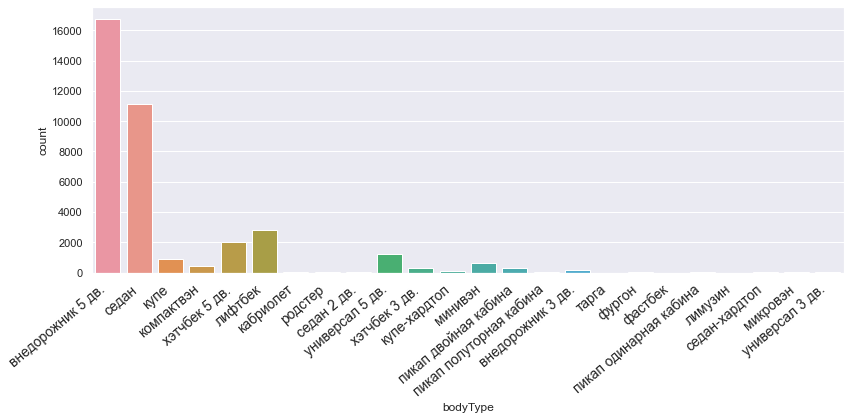

In [57]:
build_plot('bodyType', train)

В тренировочном датасете так же больше всего седанов и внедорожников 5 дверных

In [58]:
train['car_url'].nunique()

36281

Видно что уникальных значений меньше чем количество строк в датасете.
Соответственно есть дубликаты, удалим их

In [59]:
train = train.drop_duplicates(['car_url'])

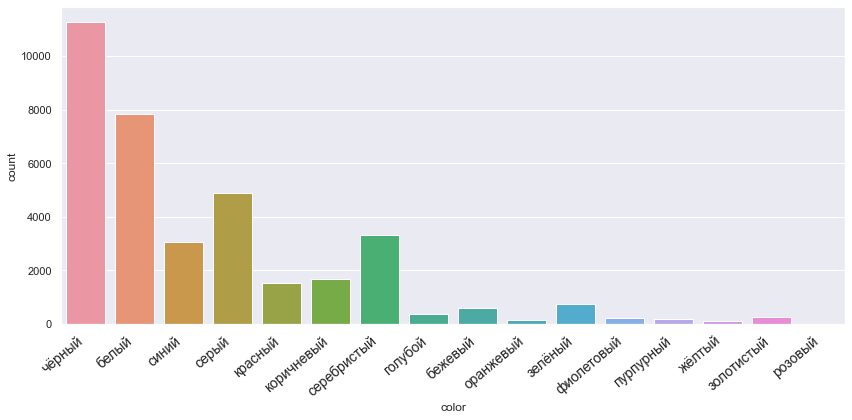

In [60]:
build_plot('color', train)

В тренировочном датасете так же больше всего машин черного цвета

In [61]:
train['fuelType'].value_counts()

Бензин     29395
Дизель      6155
Гибрид       647
Электро       84
Name: fuelType, dtype: int64

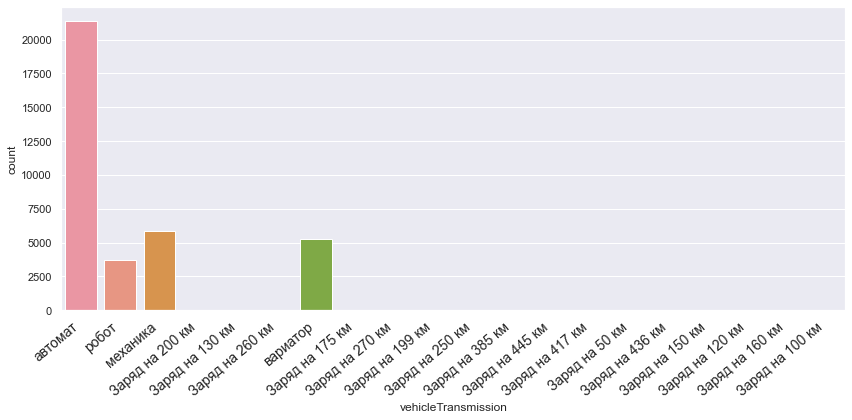

In [62]:
build_plot('vehicleTransmission', train)

В train получилось, что вместо типа трансмиссии у электромобилей указан пробег на одном заряде. Посмотрим, как это реализовано в test:

In [63]:
test[test['fuelType']=='электро']['vehicleTransmission'].value_counts()

автоматическая    55
Name: vehicleTransmission, dtype: int64

В test у электрокаров автоматическая трансмиссия. Приведем данные к единому типу заменив значения в train:

In [64]:
train['vehicleTransmission'] = train['vehicleTransmission'].apply(lambda x:
                                                                  'автоматическая' if re.search(r'Заряд', x) else x)

In [65]:
transmission_map = {'автомат': 'автоматическая', 'робот': 'роботизированная', 'механика': 'механическая',
                    'вариатор': 'вариатор'}

train['vehicleTransmission'] = train['vehicleTransmission'].map(transmission_map)

In [66]:
train['vehicleTransmission'].value_counts()

автоматическая      21364
механическая         5881
вариатор             5273
роботизированная     3684
Name: vehicleTransmission, dtype: int64

Изменили данные в тренирочном датасете на такие же исходные как в тестовом

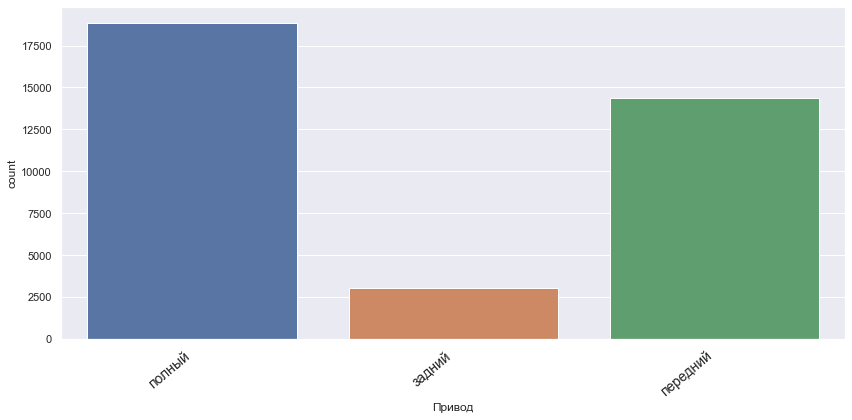

In [67]:
build_plot('Привод', train)

Полноприводных машин больше

In [68]:
train['productionDate'].value_counts(bins=4)

(1999.75, 2021.0]      33707
(1978.5, 1999.75]       2552
(1957.25, 1978.5]         19
(1935.914, 1957.25]        3
Name: productionDate, dtype: int64

Большинство машин с 2000 по 2021 год выпуска

In [69]:
train['mileage'].value_counts(bins=4)

(-999.0, 250000.75]       31949
(250000.75, 500000.5]      4257
(500000.5, 750000.25]        61
(750000.25, 1000000.0]       14
Name: mileage, dtype: int64

In [70]:
train['mileage'].sort_values(ascending=False)

20978    1000000
27220    1000000
30477    1000000
17127     999999
3601      999999
          ...   
13348          1
24156          1
7502           1
14558          1
13742          1
Name: mileage, Length: 36281, dtype: int64

Странное значение -999, но после проверки оказалось что минимальное значение 1, соответственно у преобладающего количества машин пробег от 1 до 250 000 км

In [71]:
train['price'].sort_values(ascending=False)

9023     59900000
7319     55000000
7280     50000000
7610     28700000
10860    27900000
           ...   
16422       28000
19348       27000
30026       27000
17903       25000
16655       20000
Name: price, Length: 36281, dtype: int64

In [72]:
train['car_url'][(train['price'] == 20000) | (train['price'] == 25000) | (train['price'] == 59900000)].unique()

array(['https://auto.ru/cars/used/sale/mercedes/s_class_maybach/1103849519-07595ace/',
       'https://auto.ru/cars/used/sale/audi/80/1101887355-d10fed5e/',
       'https://auto.ru/cars/used/sale/audi/100/1103823209-d7351dc4/'],
      dtype=object)

Разброс цен огромный, посмотрели на объявления все адекватно
20 тыс - стоят старые машины
почти 60 млн - 6 литровый майбах

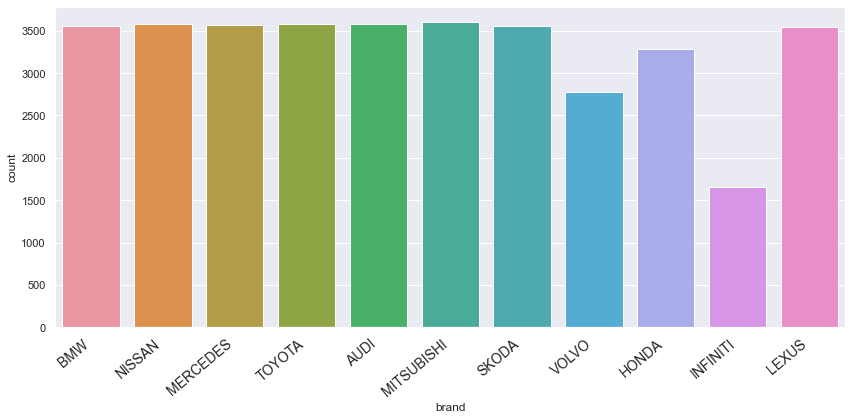

In [73]:
build_plot('brand', train)

Распределение по маркам автомобилей относительно равномерное

In [74]:
train['model_name'].value_counts()

OCTAVIA        1429
RX             1273
OUTLANDER       823
CAMRY           778
QASHQAI         752
               ... 
REGIUS            1
PRESEA            1
VANEO             1
TITAN             1
N_BOX_SLASH       1
Name: model_name, Length: 532, dtype: int64

В датасете присутствуют 465 разных модели машины

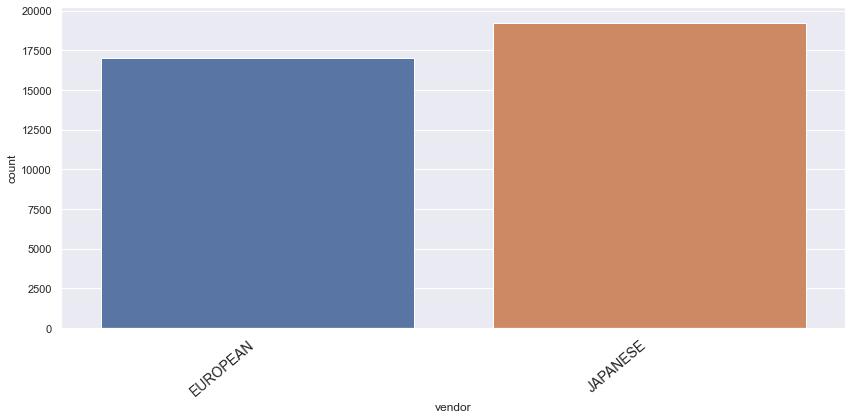

In [75]:
build_plot('vendor', train)

Большинство автомобилей европейских производителей

In [76]:
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float64')
train['engineDisplacement'].value_counts(bins=4)

(1.65, 3.3]        22541
(-0.0076, 1.65]     7787
(3.3, 4.95]         4718
(4.95, 6.6]         1235
Name: engineDisplacement, dtype: int64

Большинство машин имеют объем двигателя от 1.6 до 3.3

In [77]:
train['enginePower'] = train['enginePower'].values.astype('int64')
train['enginePower'].value_counts(bins=4)

(6.276, 187.75]    20615
(187.75, 368.5]    14022
(368.5, 549.25]     1272
(549.25, 730.0]      372
Name: enginePower, dtype: int64

 Большинство машин имеют мощность двигателя от 7 до 188 л.с.

In [78]:
fuelType_map = {'Бензин': 'бензин', 'Дизель': 'дизель', 'Электро': 'электро', 'Гибрид': 'гибрид'}

train['fuelType'] = train['fuelType'].map(fuelType_map)

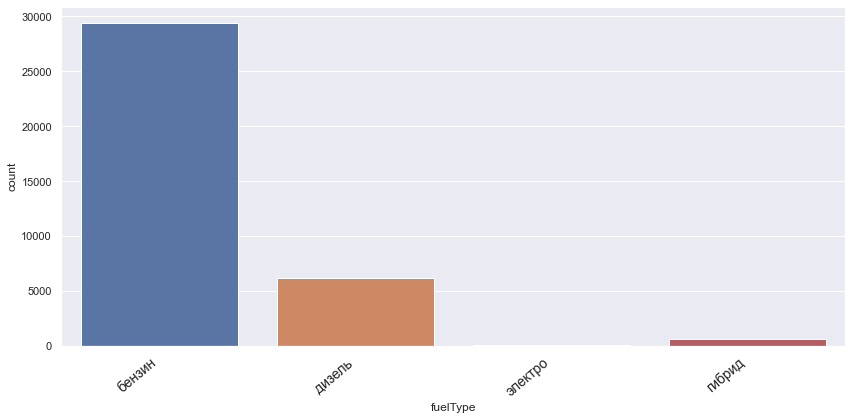

In [79]:
build_plot('fuelType', train)

Большинство машин на бензине

In [80]:
train.columns

Index(['bodyType', 'car_url', 'color', 'vehicleTransmission', 'Привод',
       'productionDate', 'mileage', 'price', 'sale_year', 'brand',
       'model_name', 'vendor', 'engineDisplacement', 'enginePower',
       'fuelType'],
      dtype='object')

In [81]:
print('Размерность тренировочного датасета: ', train.shape)

Размерность тренировочного датасета:  (36281, 15)


In [82]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'model_name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'sale_year'],
      dtype='object')

In [83]:
#посмотрим какие колонки из data_test есть в data_train

#создадим пустой список, в который добавим колонки data_test, присутствующие в data_train
in_train = []
#создадим пустой список, в который добавим колонки data_test, отсутствующие в data_train
not_in_train = []

for column in test.columns:
    if column in train.columns:
        in_train.append(column)
    else:
        not_in_train.append(column)

In [84]:
in_train

['bodyType',
 'brand',
 'car_url',
 'color',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'model_name',
 'productionDate',
 'vehicleTransmission',
 'vendor',
 'Привод',
 'sale_year']

In [85]:
not_in_train

['equipment_dict', 'numberOfDoors', 'Владельцы', 'ПТС', 'Руль']

In [86]:
test.drop(['equipment_dict', 'numberOfDoors', 'Владельцы', 'ПТС', 'Руль'], axis = 1, inplace=True)

In [87]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  object 
 1   brand                34686 non-null  object 
 2   car_url              34686 non-null  object 
 3   color                34686 non-null  object 
 4   engineDisplacement   34686 non-null  float64
 5   enginePower          34686 non-null  int64  
 6   fuelType             34686 non-null  object 
 7   mileage              34686 non-null  int64  
 8   model_name           34686 non-null  object 
 9   productionDate       34686 non-null  int64  
 10  vehicleTransmission  34686 non-null  object 
 11  vendor               34686 non-null  object 
 12  Привод               34686 non-null  object 
 13  sale_year            34686 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 3.7+ MB


Ставим метки 'sample'= 1 or 0 для того чтоб отличать train и test и склеиваем выбранные столбцы.
Назовем полученный датасет cars, он будет использоваться для EDA

In [88]:
train['sample'] = 1
test['sample'] = 0
cars = train.append(test, ignore_index=True, sort=False)

Проверим итоговый датасет на наличие дубликатов по уникальному столбцу car_url

In [89]:
cars['car_url'].nunique()

70584

In [90]:
cars = cars.drop_duplicates('car_url', keep = 'last')

In [91]:
cars.info()
cars=cars.reset_index()
cars

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70584 entries, 0 to 70966
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             70584 non-null  object 
 1   car_url              70584 non-null  object 
 2   color                70584 non-null  object 
 3   vehicleTransmission  70506 non-null  object 
 4   Привод               70584 non-null  object 
 5   productionDate       70584 non-null  int64  
 6   mileage              70584 non-null  int64  
 7   price                35898 non-null  float64
 8   sale_year            70584 non-null  int64  
 9   brand                70584 non-null  object 
 10  model_name           70584 non-null  object 
 11  vendor               70584 non-null  object 
 12  engineDisplacement   70584 non-null  float64
 13  enginePower          70584 non-null  int64  
 14  fuelType             70584 non-null  object 
 15  sample               70584 non-null 

,index,bodyType,car_url,color,vehicleTransmission,Привод,productionDate,mileage,price,sale_year,brand,model_name,vendor,engineDisplacement,enginePower,fuelType,sample
0,0,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x5_m/110359...,чёрный,автоматическая,полный,2015,53000,4700000.0,2021,BMW,X5_M,EUROPEAN,4.4,575,бензин,1
1,1,седан,https://auto.ru/cars/used/sale/bmw/5er/1103881...,белый,автоматическая,полный,2019,43900,3940000.0,2021,BMW,5ER,EUROPEAN,3.0,249,дизель,1
2,2,седан,https://auto.ru/cars/used/sale/bmw/m5/11034992...,синий,автоматическая,полный,2020,7900,11450000.0,2021,BMW,M5,EUROPEAN,4.4,625,бензин,1
3,3,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x5/11036267...,чёрный,автоматическая,полный,2010,280000,850000.0,2021,BMW,X5,EUROPEAN,3.0,306,дизель,1
4,4,купе,https://auto.ru/cars/used/sale/bmw/m4/10767461...,синий,роботизированная,задний,2017,7200,5500000.0,2021,BMW,M4,EUROPEAN,3.0,450,бензин,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70579,70962,седан,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,автоматическая,задний,2014,115000,NaN,2020,BMW,3ER,EUROPEAN,1.6,136,бензин,0
70580,70963,седан,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,автоматическая,полный,2018,98000,NaN,2020,BMW,5ER,EUROPEAN,2.0,190,дизель,0
70581,70964,седан,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,автоматическая,задний,1997,360000,NaN,2020,BMW,5ER,EUROPEAN,2.5,170,бензин,0
70582,70965,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,автоматическая,полный,2013,90500,NaN,2020,BMW,X1,EUROPEAN,2.0,184,дизель,0


Проверим не удалились ли строки с тестового датасета

In [92]:
cars[cars['sample'] == 0]

,index,bodyType,car_url,color,vehicleTransmission,Привод,productionDate,mileage,price,sale_year,brand,model_name,vendor,engineDisplacement,enginePower,fuelType,sample
35898,36281,лифтбек,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,роботизированная,передний,2014,74000,NaN,2020,SKODA,OCTAVIA,EUROPEAN,1.2,105,бензин,0
35899,36282,лифтбек,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,механическая,передний,2017,60563,NaN,2020,SKODA,OCTAVIA,EUROPEAN,1.6,110,бензин,0
35900,36283,лифтбек,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,роботизированная,передний,2014,88000,NaN,2020,SKODA,SUPERB,EUROPEAN,1.8,152,бензин,0
35901,36284,лифтбек,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,автоматическая,передний,2014,95000,NaN,2020,SKODA,OCTAVIA,EUROPEAN,1.6,110,бензин,0
35902,36285,лифтбек,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,автоматическая,передний,2012,58536,NaN,2020,SKODA,OCTAVIA,EUROPEAN,1.8,152,бензин,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70579,70962,седан,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,автоматическая,задний,2014,115000,NaN,2020,BMW,3ER,EUROPEAN,1.6,136,бензин,0
70580,70963,седан,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,автоматическая,полный,2018,98000,NaN,2020,BMW,5ER,EUROPEAN,2.0,190,дизель,0
70581,70964,седан,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,автоматическая,задний,1997,360000,NaN,2020,BMW,5ER,EUROPEAN,2.5,170,бензин,0
70582,70965,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,автоматическая,полный,2013,90500,NaN,2020,BMW,X1,EUROPEAN,2.0,184,дизель,0


In [93]:
print('Размерность итогового датасета: ', cars.shape)

Размерность итогового датасета:  (70584, 17)


## EDA

Создадим списки с разделением по типу переменных

In [94]:
cat_cols = ['bodyType', 'color', 'vehicleTransmission', 'Привод', 'brand',
            'model_name', 'vendor', 'fuelType']
num_cols = ['productionDate', 'mileage', 'engineDisplacement', 'enginePower','sale_year']

### Рассмотрим категориальные признаки

Прологарифмируем целевую переменную для корректной визуализации

In [95]:
cars['log_price'] = np.log(cars.price)

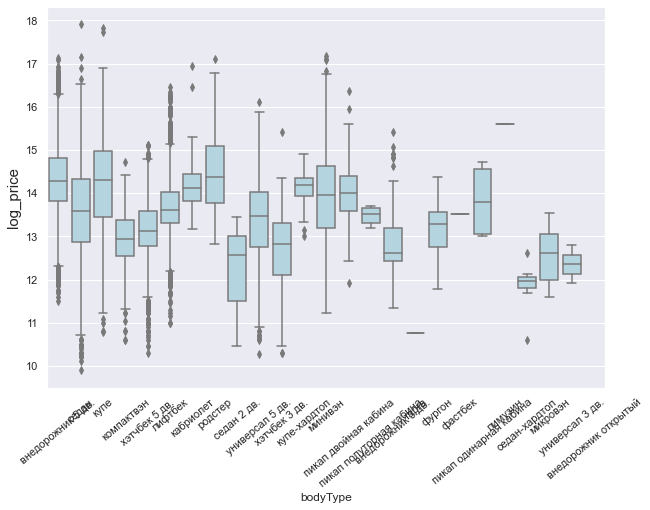

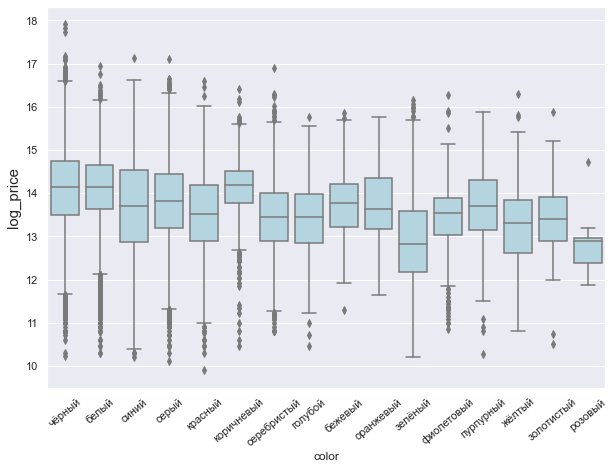

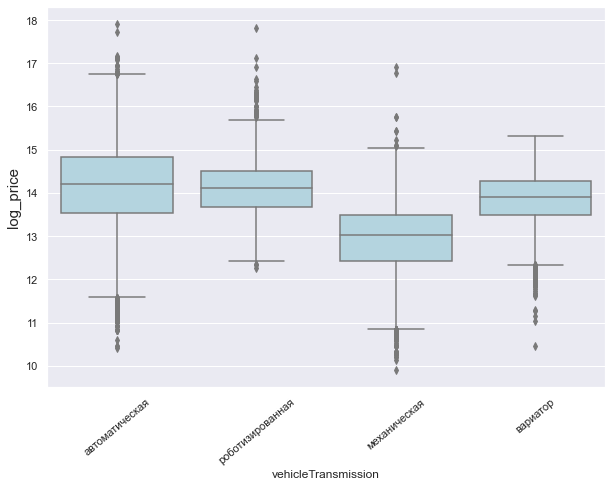

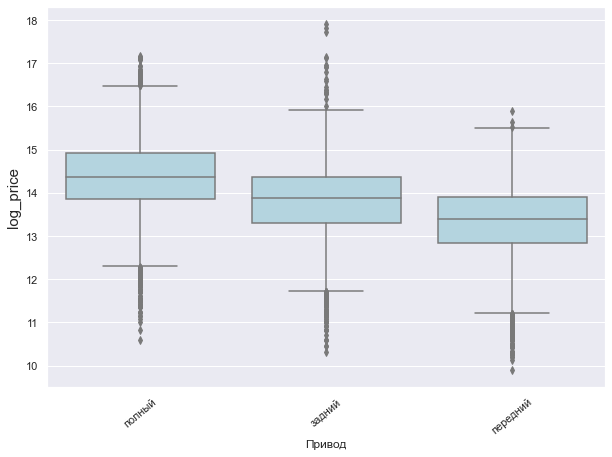

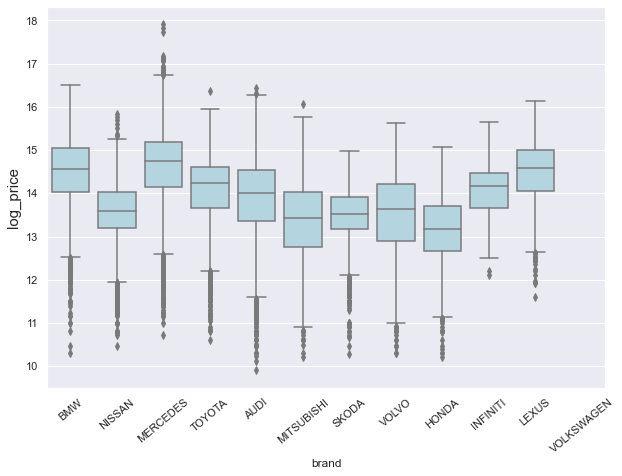

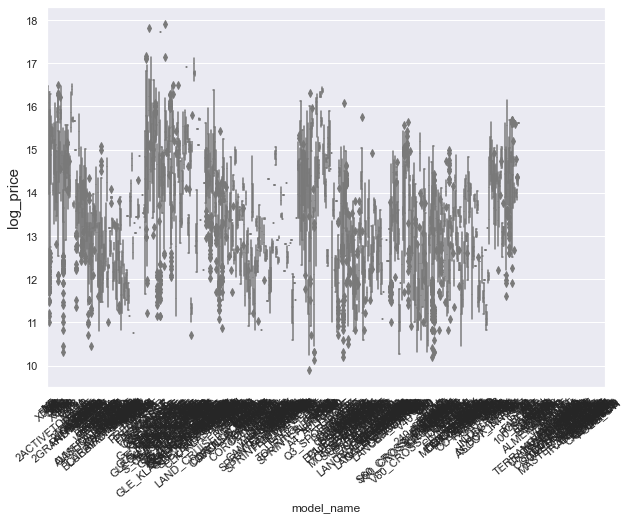

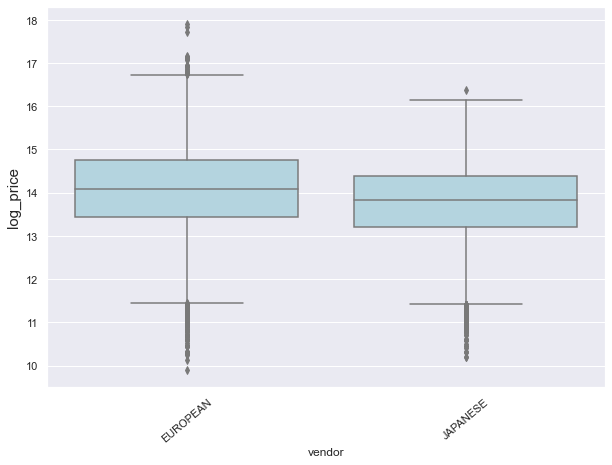

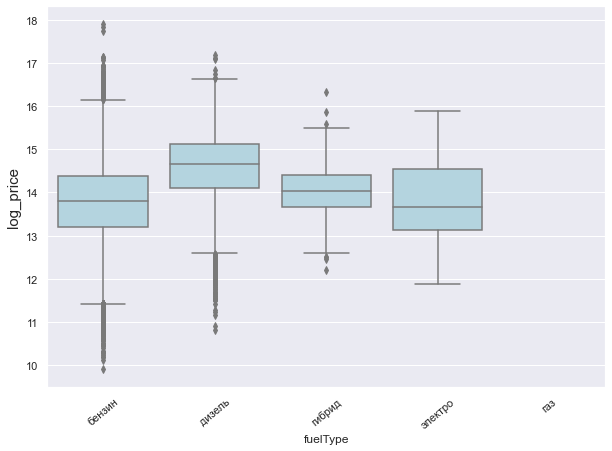

In [96]:
for i in cat_cols:
    build_log_plot(i, cars)
    plt.show()

Разброс по всем параметрам вполне адекватный

Автомобили с автоматической коробкой передач самые дорогие, с механической - самые дешевые  
Полноприводные автомобили дороже  
Средняя цена у автомобилей на дизеле выше всех

Исходя из вывода выше удалим столбцы с цветом и производителем

In [97]:
#cars.drop(['color', 'vendor'], axis = 1, inplace=True)

In [98]:
#cat_cols_new = ['bodyType', 'vehicleTransmission', 'Привод', 'brand',
#           'model_name', 'fuelType']

### Рассмотрим числовые признаки

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


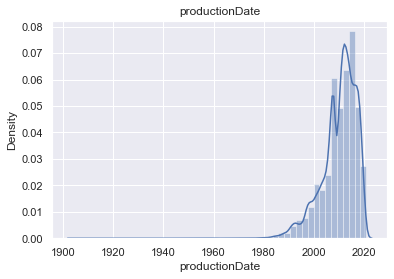

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


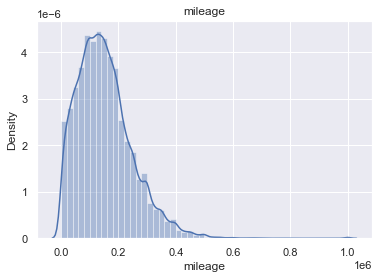

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


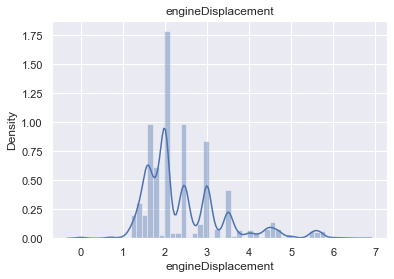

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


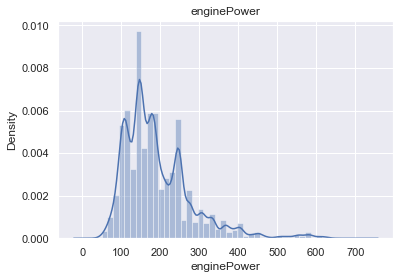

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


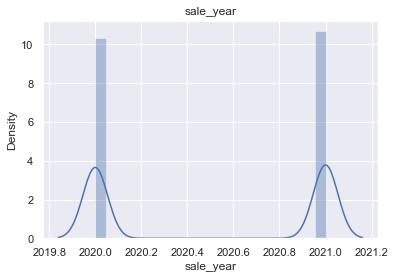

In [99]:
for i in num_cols:
    plt.figure()
    sns.distplot(cars[i])
    plt.title(i)
    plt.show()

Распределения у признаков близки к нормальным, справа или слева имеются длинные хвосты.
Посмотрим на выбросы

In [100]:
for i in num_cols:
    print(i, len(outliers_iqr(cars[i])))

productionDate 2425
mileage 1658
engineDisplacement 2324
enginePower 2583
sale_year 0


Не будем с ними ничего не делать, так как в масштабах всего датасета их не так уж и много

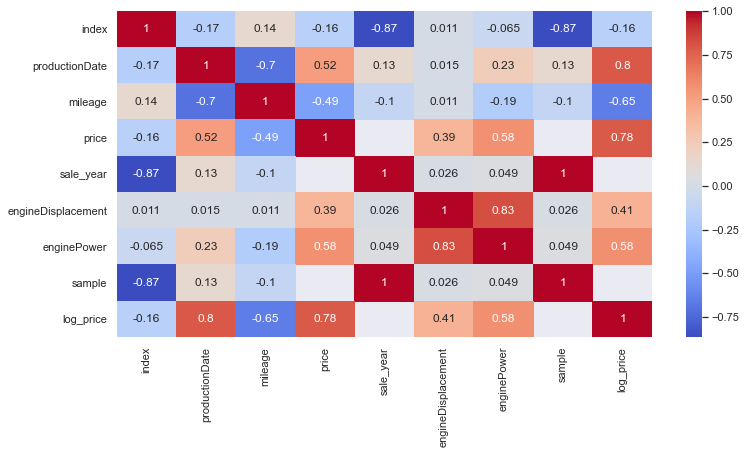

In [101]:
heatmap(cars)

Видно что самая наибольшая корреляция у признаков engineDisplacement & enginePower, что логично  
С целевой переменной наибольшую корреляцию составляет признак enginePower  
Но в то же время все признаки неплохо скоррелированы с целевой переменной

Самая наименьшая корреляция у признака engineDisplacement и productionDate, тоже логично

Так как все признаки уже приведены к корректному виду, построим графики для категориальных переменных, чтобы убедиться что ничего лишнего не возникает

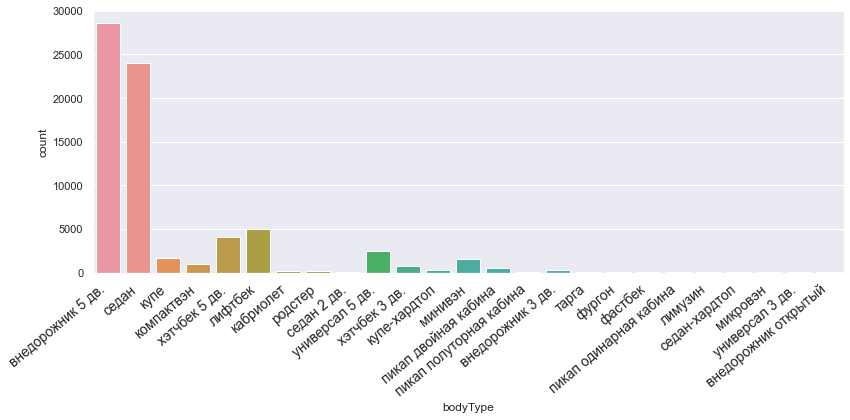

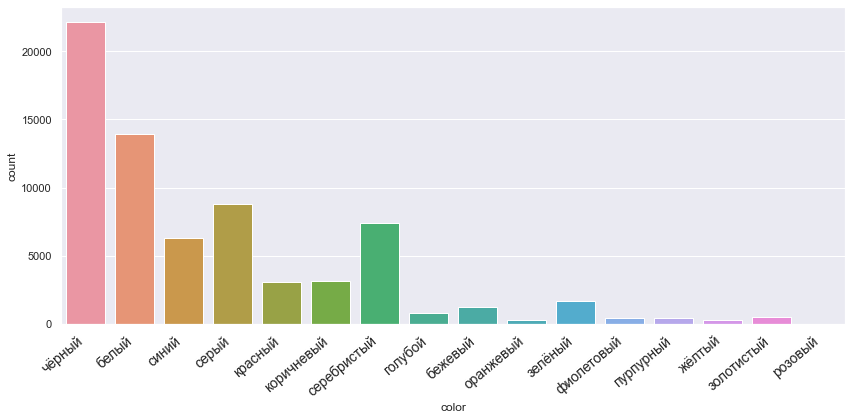

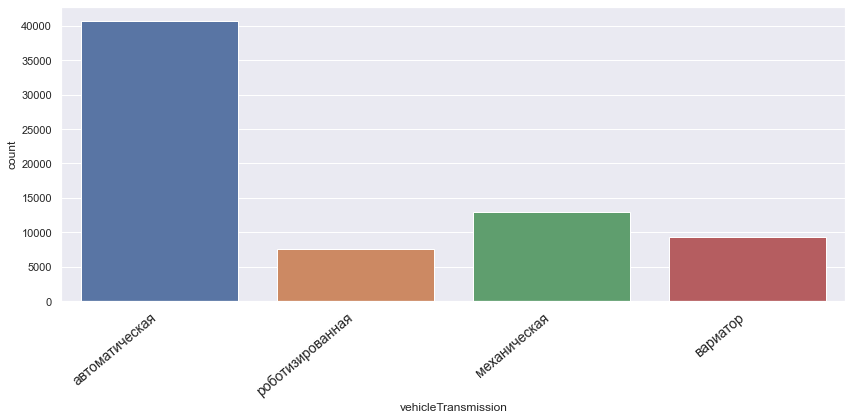

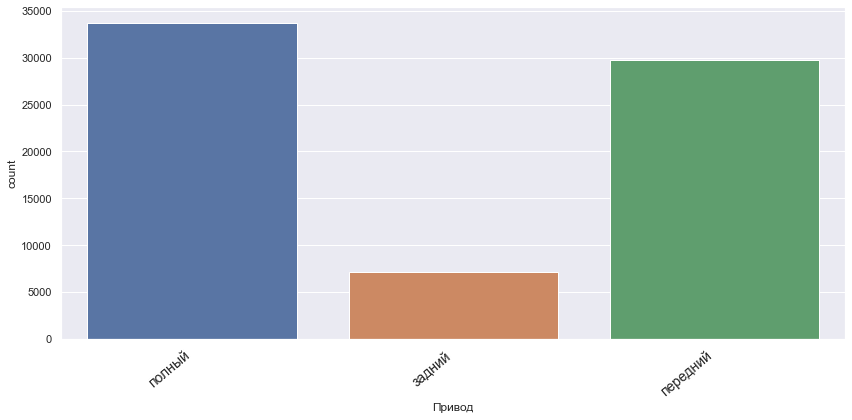

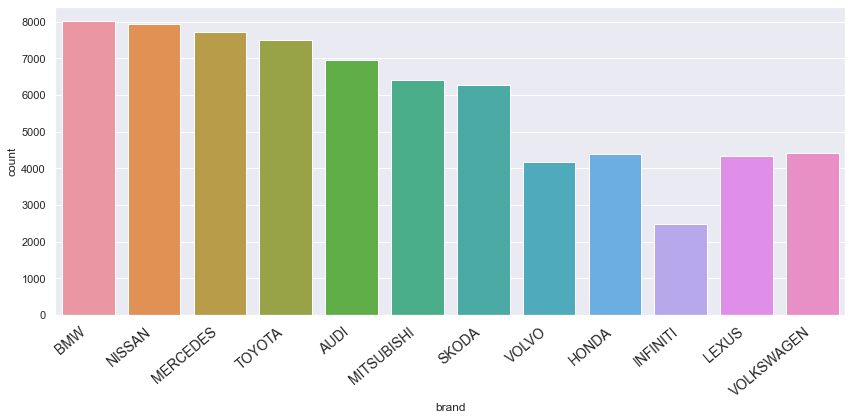

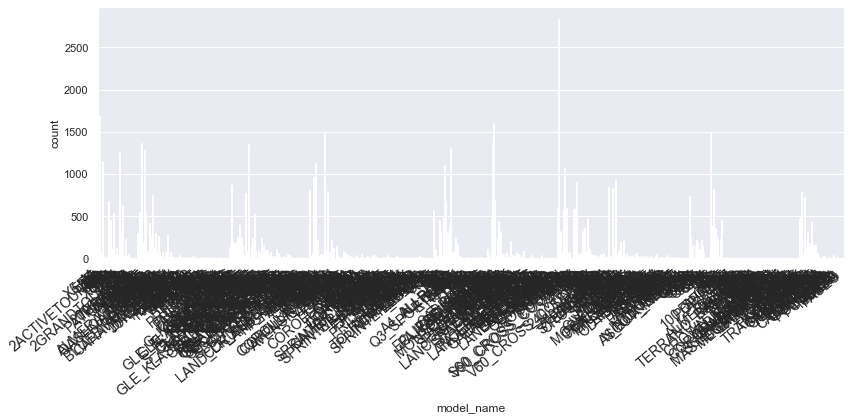

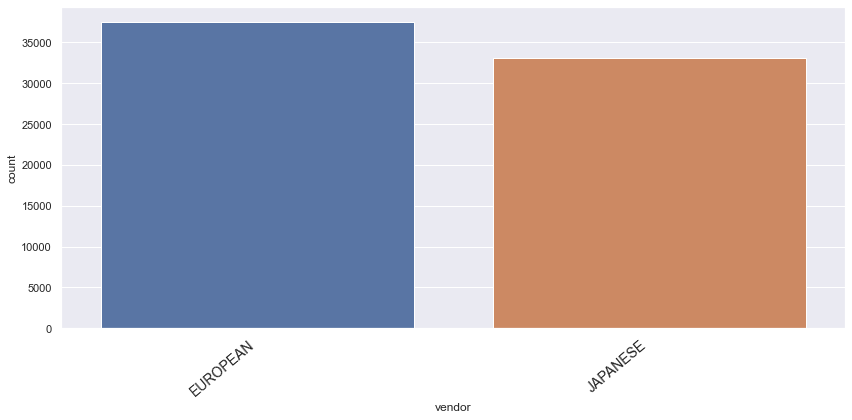

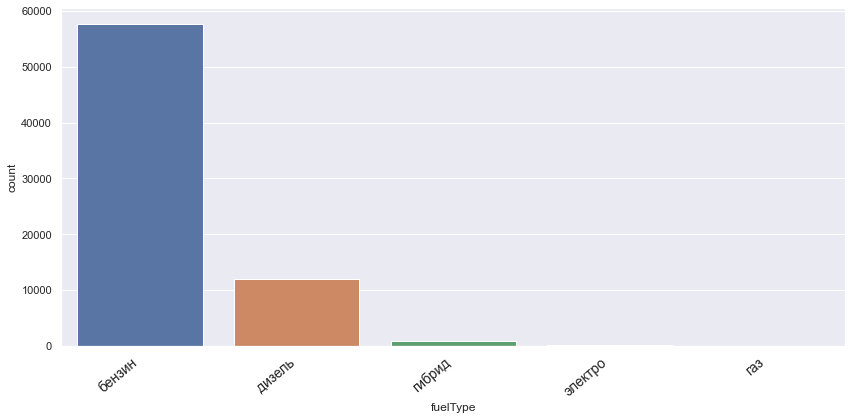

In [102]:
for i in cat_cols:
    build_plot(i, cars)

# Feature Engineering

Перейдем к генерации новых признаков

Создадим новый столбец bodyClass оставляя более широкое название, тем самым избавившись от различных наименований и значительно сократив число разных типов

In [103]:
cars.bodyType.value_counts()

внедорожник 5 дв.          28621
седан                      23947
лифтбек                     4937
хэтчбек 5 дв.               4115
универсал 5 дв.             2451
купе                        1674
минивэн                     1582
компактвэн                   924
хэтчбек 3 дв.                748
пикап двойная кабина         552
внедорожник 3 дв.            270
купе-хардтоп                 253
родстер                      151
кабриолет                    145
фургон                       113
микровэн                      33
седан-хардтоп                 19
пикап полуторная кабина       13
пикап одинарная кабина        10
седан 2 дв.                    9
лимузин                        7
внедорожник открытый           3
тарга                          3
универсал 3 дв.                2
фастбек                        2
Name: bodyType, dtype: int64

In [104]:
def get_bodyClass(bodyType):
    
    bodyClass = 'other'
    
    dict_bodyTypes = {'внедорожник' : ['внедорожник 5 дв.', 'внедорожник 3 дв.', 'внедорожник открытый',
                            'пикап полуторная кабина', 'пикап одинарная кабина', 'пикап двойная кабина'],
            'седан' : ['седан', 'лифтбек', 'хэтчбек 5 дв.', 'универсал 5 дв.', 'универсал 3 дв.', 
                       'купе', 'хэтчбек 3 дв.', 'купе-хардтоп', 'родстер', 'кабриолет', 'седан-хардтоп',
                      'седан 2 дв.', 'тарга', 'фастбек'],
            'фургон' : ['минивэн', 'компактвэн', 'фургон', 'микровэн', 'лимузин']}
    
    for key, value in dict_bodyTypes.items():   
        if bodyType in value:
            bodyClass = key
    
    return bodyClass

cars['bodyClass'] = cars.bodyType.apply(lambda x: get_bodyClass(x))
cars.bodyClass.value_counts()

седан          38456
внедорожник    29469
фургон          2659
Name: bodyClass, dtype: int64

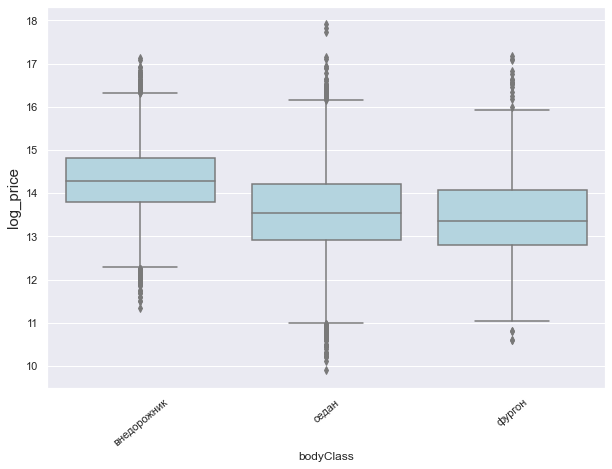

In [105]:
build_log_plot('bodyClass', cars)

Видно что средняя цена внедорожников выше, что логично
Но при этом средние цены на седаны и фургоны не сильно отличаются

Также создадим новый столбец 'color_cat', уменьшив количество вариантов цветов:

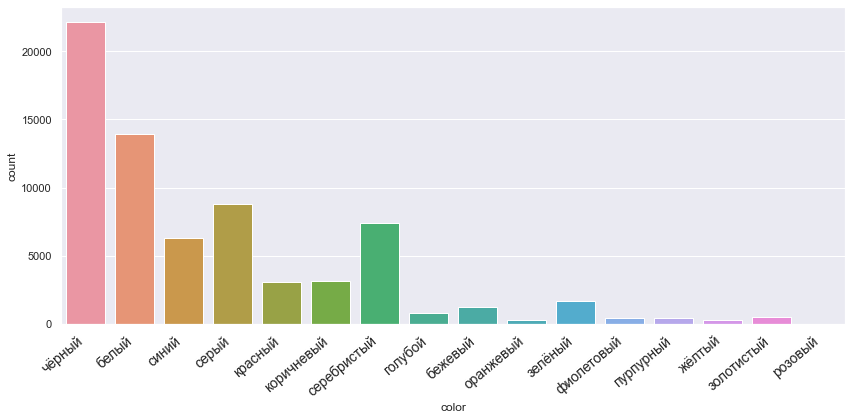

In [106]:
build_plot('color', cars)

In [107]:
def cat_color(color):
    
    color_cat = 'other'
    dict_colors = {'чёрный' : 'чёрный','белый' : 'белый',
               'серый': ['серый', 'серебристый'],
               'RGBB':['красный','зеленый','синий','коричневый']}
    
    for key, value in dict_colors.items():   
        if color in value:
            color_cat = key
    
    return color_cat

cars['color_cat'] = cars.color.apply(lambda x: cat_color(x))

In [108]:
cars['color_cat'].value_counts()

чёрный    22162
серый     16219
белый     13918
RGBB      12551
other      5734
Name: color_cat, dtype: int64

Разобьем на категории объем двигателя (микролитражные (до 1,1 л) - 0, малолитражные (1,2-1,5 л) - 1, среднелитражные (1,6-3,5 л) - 2 и крупнолитражные (свыше 3,5 л) - 3), добавим признак возраст авто 'age' и пробег в год 'km_per_year'

In [109]:
cars['engineDisplacement_cat'] = cars['engineDisplacement'].astype('float').apply(lambda x: 3 if x > 3.5 else 
   2 if x >= 1.6 else(1 if x >= 1.2 else 0))

cars['age'] = cars['sale_year'] - cars['productionDate']

cars['km_per_year'] = cars['mileage']/(cars['age']+1)

Также добавим категории по пробегу:  
до 50000км - вполне свежие  
50000 - 150000 возможно еще на гарантии  
150000 - 250000 возможно не потребуется капремонт
более 250000 скорее всего нужен капремонт

In [110]:
cars['mileage_cat'] = cars['mileage'].astype('float').apply(lambda x: 0 if x >= 250000 else 
   1 if x >= 150000 else(2 if x >= 50000 else 3 ))

Построим матрицу корреляций учитывая новые признаки

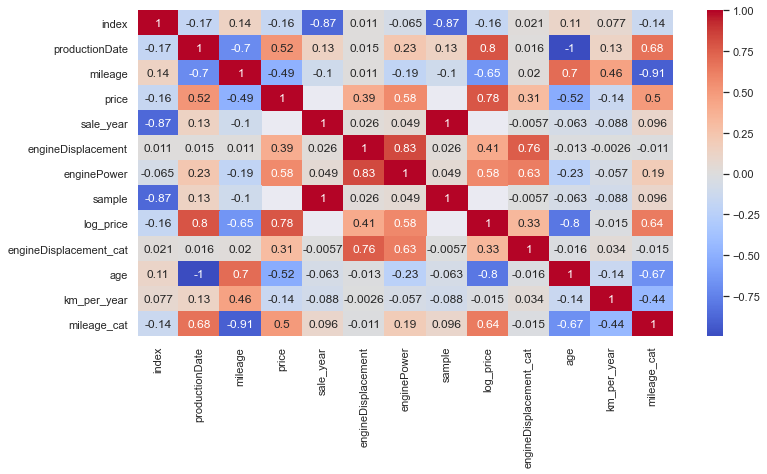

In [111]:
heatmap(cars)

Видим высокую корреляцию между следующими признаками:  'mileage' и 'mileage_cat', 'engineDisplacement' и 'enginePower'.  Для модели оставим 'mileage_cat' и 'enginePower', тк они лучше скоррелированы с целевой переменной. 

In [112]:
cars.head()

,index,bodyType,car_url,color,vehicleTransmission,Привод,productionDate,mileage,price,sale_year,...,enginePower,fuelType,sample,log_price,bodyClass,color_cat,engineDisplacement_cat,age,km_per_year,mileage_cat
0,0,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x5_m/110359...,чёрный,автоматическая,полный,2015,53000,4700000.0,2021,...,575,бензин,1,15.363073,внедорожник,чёрный,3,6,7571.428571,2
1,1,седан,https://auto.ru/cars/used/sale/bmw/5er/1103881...,белый,автоматическая,полный,2019,43900,3940000.0,2021,...,249,дизель,1,15.186691,седан,белый,2,2,14633.333333,3
2,2,седан,https://auto.ru/cars/used/sale/bmw/m5/11034992...,синий,автоматическая,полный,2020,7900,11450000.0,2021,...,625,бензин,1,16.253500,седан,RGBB,3,1,3950.000000,3
3,3,внедорожник 5 дв.,https://auto.ru/cars/used/sale/bmw/x5/11036267...,чёрный,автоматическая,полный,2010,280000,850000.0,2021,...,306,дизель,1,13.652992,внедорожник,чёрный,2,11,23333.333333,0
4,4,купе,https://auto.ru/cars/used/sale/bmw/m4/10767461...,синий,роботизированная,задний,2017,7200,5500000.0,2021,...,450,бензин,1,15.520259,седан,RGBB,2,4,1440.000000,3


После FE добавлены 6 новых признаков:  
2 категориальных ['color_cat','bodyClass'], 2 ординальных ['mileage_cat','engineDisplacement_cat']  и 2 числовых ['age','km_per_year']


In [113]:
cat_cols = ['bodyType', 'color', 'vehicleTransmission', 'Привод', 'brand',
            'model_name', 'vendor', 'fuelType']

Перекодируем категориальные признаки с помощью dummy-переменных

In [114]:
dummies = pd.get_dummies(cars[['vehicleTransmission','Привод','brand','vendor','fuelType','bodyClass','color_cat']])


Убираем преобразованные категориальные колонки, 'sale_year'(она была необходима для создания новых признаков) и 'mileage','engineDisplacement':

In [115]:
cars.drop(['vehicleTransmission','Привод','brand','vendor',
           'fuelType','bodyClass','color_cat','model_name',
           'bodyType', 'color','car_url', 'sale_year','mileage','engineDisplacement'], axis=1, inplace=True)
cars_ML = pd.concat([cars, dummies], axis=1)
cars_ML

,index,productionDate,price,enginePower,sample,log_price,engineDisplacement_cat,age,km_per_year,mileage_cat,...,fuelType_дизель,fuelType_электро,bodyClass_внедорожник,bodyClass_седан,bodyClass_фургон,color_cat_RGBB,color_cat_other,color_cat_белый,color_cat_серый,color_cat_чёрный
0,0,2015,4700000.0,575,1,15.363073,3,6,7571.428571,2,...,0,0,1,0,0,0,0,0,0,1
1,1,2019,3940000.0,249,1,15.186691,2,2,14633.333333,3,...,1,0,0,1,0,0,0,1,0,0
2,2,2020,11450000.0,625,1,16.253500,3,1,3950.000000,3,...,0,0,0,1,0,1,0,0,0,0
3,3,2010,850000.0,306,1,13.652992,2,11,23333.333333,0,...,1,0,1,0,0,0,0,0,0,1
4,4,2017,5500000.0,450,1,15.520259,2,4,1440.000000,3,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70579,70962,2014,NaN,136,0,NaN,2,6,16428.571429,2,...,0,0,0,1,0,1,0,0,0,0
70580,70963,2018,NaN,190,0,NaN,2,2,32666.666667,2,...,1,0,0,1,0,0,0,0,0,1
70581,70964,1997,NaN,170,0,NaN,2,23,15000.000000,0,...,0,0,0,1,0,0,0,0,1,0
70582,70965,2013,NaN,184,0,NaN,2,7,11312.500000,2,...,1,0,1,0,0,1,0,0,0,0


# Построение моделей

In [116]:
cars_ML = cars_ML.reset_index()
cars_ML.drop('index', axis=1, inplace=True)

In [117]:
cars_ML.columns[:]

Index(['level_0', 'productionDate', 'price', 'enginePower', 'sample',
       'log_price', 'engineDisplacement_cat', 'age', 'km_per_year',
       'mileage_cat', 'vehicleTransmission_автоматическая',
       'vehicleTransmission_вариатор', 'vehicleTransmission_механическая',
       'vehicleTransmission_роботизированная', 'Привод_задний',
       'Привод_передний', 'Привод_полный', 'brand_AUDI', 'brand_BMW',
       'brand_HONDA', 'brand_INFINITI', 'brand_LEXUS', 'brand_MERCEDES',
       'brand_MITSUBISHI', 'brand_NISSAN', 'brand_SKODA', 'brand_TOYOTA',
       'brand_VOLKSWAGEN', 'brand_VOLVO', 'vendor_EUROPEAN', 'vendor_JAPANESE',
       'fuelType_бензин', 'fuelType_газ', 'fuelType_гибрид', 'fuelType_дизель',
       'fuelType_электро', 'bodyClass_внедорожник', 'bodyClass_седан',
       'bodyClass_фургон', 'color_cat_RGBB', 'color_cat_other',
       'color_cat_белый', 'color_cat_серый', 'color_cat_чёрный'],
      dtype='object')

In [118]:
# Разделяем обратно train и test, в train отделяем целевую переменную Y
X = cars_ML[cars_ML['sample'] == 1].drop(['price','log_price','sample'], axis=1)
Y = cars_ML[cars_ML['sample'] == 1]['price']
X_sub = cars_ML[cars_ML['sample'] == 0].drop(['price','log_price','sample'], axis=1)

In [136]:
test

,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,vendor,Привод,sale_year,sample
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105,бензин,74000,OCTAVIA,2014,роботизированная,EUROPEAN,передний,2020,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110,бензин,60563,OCTAVIA,2017,механическая,EUROPEAN,передний,2020,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152,бензин,88000,SUPERB,2014,роботизированная,EUROPEAN,передний,2020,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110,бензин,95000,OCTAVIA,2014,автоматическая,EUROPEAN,передний,2020,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152,бензин,58536,OCTAVIA,2012,автоматическая,EUROPEAN,передний,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,1.6,136,бензин,115000,3ER,2014,автоматическая,EUROPEAN,задний,2020,0
34682,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,2.0,190,дизель,98000,5ER,2018,автоматическая,EUROPEAN,полный,2020,0
34683,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,2.5,170,бензин,360000,5ER,1997,автоматическая,EUROPEAN,задний,2020,0
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,2.0,184,дизель,90500,X1,2013,автоматическая,EUROPEAN,полный,2020,0


In [135]:
X_sub

,level_0,productionDate,enginePower,engineDisplacement_cat,age,km_per_year,mileage_cat,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,...,fuelType_дизель,fuelType_электро,bodyClass_внедорожник,bodyClass_седан,bodyClass_фургон,color_cat_RGBB,color_cat_other,color_cat_белый,color_cat_серый,color_cat_чёрный
35898,35898,2014,105,1,6,10571.428571,2,0,0,0,...,0,0,0,1,0,1,0,0,0,0
35899,35899,2017,110,2,3,15140.750000,2,0,0,1,...,0,0,0,1,0,0,0,0,0,1
35900,35900,2014,152,2,6,12571.428571,2,0,0,0,...,0,0,0,1,0,0,0,0,1,0
35901,35901,2014,110,2,6,13571.428571,2,1,0,0,...,0,0,0,1,0,1,0,0,0,0
35902,35902,2012,152,2,8,6504.000000,2,1,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70579,70579,2014,136,2,6,16428.571429,2,1,0,0,...,0,0,0,1,0,1,0,0,0,0
70580,70580,2018,190,2,2,32666.666667,2,1,0,0,...,1,0,0,1,0,0,0,0,0,1
70581,70581,1997,170,2,23,15000.000000,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
70582,70582,2013,184,2,7,11312.500000,2,1,0,0,...,1,0,1,0,0,1,0,0,0,0


In [119]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, shuffle=True, 
                                                            random_state=RANDOM_SEED)


In [120]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### CatBoost

In [140]:
cb = CatBoostRegressor(iterations = 5000, learning_rate = 0.15, random_seed = RANDOM_SEED, 
                          eval_metric='MAPE', custom_metric=['R2', 'MAE'], silent=True, ) 
cb.fit(X_train, np.log(y_train),
     eval_set=(X_test, np.log(y_test)),
     verbose_eval=0,
     use_best_model=True,
     )

predict_test = np.exp(cb.predict(X_test))
#predict_submission = np.exp(cb.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.46%


### GradientBoosting

In [122]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

predict_test = np.exp(gb.predict(X_test))
#predict_submission = np.exp(gb.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")


Точность модели по метрике MAPE: 13.57%


### RandomForest

In [123]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = RANDOM_SEED, oob_score=True,) 
rfr.fit(X_train, np.log(y_train))

predict_test = np.exp(rfr.predict(X_test))
#predict_submission = np.exp(rfr.predict(X_sub))


print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.68%


### XGBoost

In [124]:
xgb = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, 
                      max_depth=15, reg_alpha=1.5, n_jobs=-1, n_estimators=1000)
xgb.fit(X_train, np.log(y_train))

predict_test = np.exp(xgb.predict(X_test))
#predict_submission = np.exp(xgb.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.31%


### Бэггинг

In [125]:
tree = DecisionTreeRegressor(max_features=0.7, max_depth=10)
tree.fit(X_train, np.log(y_train))

predict_test = np.exp(tree.predict(X_test))
#predict_submission = np.exp(tree.predict(X_sub))

print(f"Точность модели по метрике MAPE: {mape(y_test, predict_test)*100:0.2f}%")

Точность модели по метрике MAPE: 18.46%


In [126]:
bagging_trees = BaggingRegressor(tree)
bagging_trees.fit(X_train, np.log(y_train))

predict_test = np.exp(tree.predict(X_test))
#predict_submission = np.exp(tree.predict(X_sub))

print(f"Точность модели по метрике MAPE: {mape(y_test, predict_test)*100:0.2f}%")

Точность модели по метрике MAPE: 18.46%


### Стекинг

In [127]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv, X_sub):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)
    
    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)
    
    X_meta_test = meta_regr.predict(X_test)
    X_meta_sub = meta_regr.predict(X_sub)

    return X_meta_train, X_meta_test, X_meta_sub

def generate_meta_features(regr, X_train, X_test, y_train, cv, X_sub):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv, X_sub)
        for regr in tqdm(regr)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test, features_sub in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test, features_sub in features
    ]).T
    
    stacked_features_sub = np.vstack([
        features_sub for features_train, features_test, features_sub in features
    ]).T
    
    return stacked_features_train, stacked_features_test, stacked_features_sub

In [129]:
y_train = y_train.to_numpy()

In [130]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test, stacked_features_sub  = generate_meta_features([
    #AdaBoostRegressor(random_state=RANDOM_SEED),
    ExtraTreesRegressor(random_state=RANDOM_SEED),  
    RandomForestRegressor(random_state=RANDOM_SEED)
    #GradientBoostingRegressor(random_state=RANDOM_SEED)
    #xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, 
                      #max_depth=12, reg_alpha=1.5, n_jobs=-1, n_estimators=500)
], X_train, X_test, y_train, cv, X_sub)

In [131]:
regr = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, 
                      max_depth=12, reg_alpha=1.5, n_jobs=-1, n_estimators=500)

print(f'Точность модели по метрике MAPE: {(mape_2(regr, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test, y_test=y_test)):0.2f}%')

Точность модели по метрике MAPE: 15.78%


### Submission

In [142]:
predict_submission = np.exp(xgb.predict(X_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_SI.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,2352138.500
1,1100549428,2217127.500
2,1100658222,2197267.250
3,1100937408,2165055.250
4,1101037972,2094574.625
5,1100912634,2180677.500
6,1101228730,2815850.000
7,1100165896,1922575.625
8,1100768262,2903044.000
9,1101218501,2602641.750


In [145]:
sample_submission['price'][0]

2352138.5

### Выводы

В результате обучения различных моделей, наилучший результат показала модель XGBRegressor

В ходе работы над проектом было сделано:

- Спарсен тренировочный датасет с сайта auto.ru;
- Проведена предобработка данных
- Представлена визуализация тех характеристик автомобилей
- Добавлены новые признаки
- Выбраны признаки для дальнейшего построения моделей 
- Построены 4 модели
- Реализован бэггинг/стекинг 